In [ ]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import math


# Playground Area:

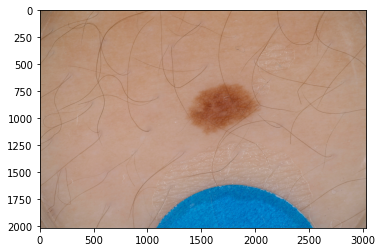

In [ ]:
# Load in the image and the segmentation
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/example_image/'#something/somthingelse/fyp2021/data/example_image/'
path=path+'ISIC_0001769.jpg'
im = plt.imread(path)
plt.imshow(im)


path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/example_segmentation/'#something/somthingelse/fyp2021/data/example_image/'
path=path+'ISIC_0001769_segmentation.png'
imseg=plt.imread(path)

In [ ]:
# Shape and dimention of the image
print(im.shape)
print(im.dtype)

(2016, 3024, 3)
uint8


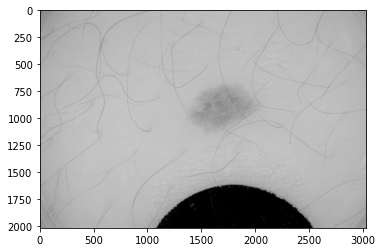

In [ ]:
# Get a single RGB value from the blue circle (marker used by dermatologist)
# print(im[2000,2000,:])

# Show only the red channel
plt.imshow(im[:,:,0],cmap='gray')

<class 'list'>
White: 352


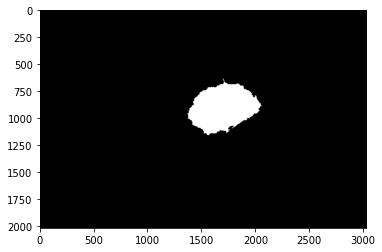

In [ ]:
plt.imshow(imseg,cmap='gray')

test = imseg[:,1500]
test = list(test)
print(type(test))
white = test.count(1)
print("White:",white)

In [ ]:
# Finding maximum and minimum height and width of the lesion.
heights=[]
widths=[]
# The range is chosen by visual inspection.
for i in range(1200,2200):
    test=imseg[:,i]
    test=list(test)
    white1=test.count(1)
    if white1!=0:
        heights.append(white1)
print('The max height is:',max(heights))
print('The min height is:',min(heights))

print()

# The range is chosen by visual inspection.
for i in range(500,1250):
    test=imseg[i]
    test=list(test)
    white=test.count(1)
    if white!=0:
        widths.append(white)
print('The max width is:',max(widths))
print('The min width is:',min(widths))

The max height is: 469
The min height is: 1

The max width is: 655
The min width is: 5


In [ ]:
# Calculating the perimeter and the area of the lesion, taking the picture as an arrray.
outline=[]
row=-1
prev=0
for i in imseg:
    column=0
    prev=0
    i=list(i)
    if 1 in i:
        for j in i:
            if j != prev and prev==0 and [column,row] not in outline:
                outline.append([column,row])
            elif j!= prev and prev==1 and [column-1,row] not in outline:
                outline.append([column-1,row])
            prev=j
            column+=1
    row+=1
column=0
for i in imseg.T:
    row=0
    prev=0
    i=list(i)
    if 1 in i:
        for j in i:
            # print(j)
            if j==1 and prev==0 and [column,row] not in outline:
                outline.append([column,row])
            elif j==0 and prev==1 and [column,row-1] not in outline:
                outline.append([column,row-1])
            prev=j
            row+=1
    column+=1
print('Perimeter is',len(outline),'pixels long')

print('The area is',sum(sum(imseg)),'pixels')

outlineset=[x[0] for x in outline]#making a set with all column numbres in the outline
outlineset=set(outlineset)

rowset=[x[1] for x in outline]#making a set with all row numbres in the outline
rowset=set(rowset)

mincol=min(outlineset)
maxcol=max(outlineset)

minrow=min(rowset)
maxrow=max(rowset)
middlerow=round((maxrow+minrow)/2)

Perimeter is 2820 pixels long
The area is 216160.0 pixels


In [ ]:
#cutting down the image to only the relevant area
imseg=imseg[minrow-5:maxrow+5,mincol-5:maxcol+5]
value=0
for i in im:
    value+=1
print(value)
red=im[minrow-5:maxrow+5,mincol-5:maxcol+5,0]
green=im[minrow-5:maxrow+5,mincol-5:maxcol+5,1]
blue=im[minrow-5:maxrow+5,mincol-5:maxcol+5,2]
im=np.dstack([red,green,blue])

2016


In [ ]:
#getting rid of all the skin
red=pd.DataFrame(im[:,:,0])
green=pd.DataFrame(im[:,:,1])
blue=pd.DataFrame(im[:,:,2])

maskedr=red.mask(imseg==1)
maskedg=green.mask(imseg==1)
maksedb=blue.mask(imseg==1)
masked = np.dstack([maskedr,maskedg,maksedb])
masked[1,1,:]

array([190., 148., 124.])

In [ ]:
#flattening the color arrays and getting them ready for histograms by getting rid of the nan values 
flatr=masked[:,:,0].flatten()
cleanr = [x for x in flatr if str(x) != 'nan']

flatg=masked[:,:,1].flatten()
cleang = [x for x in flatg if str(x) != 'nan']

flatb=masked[:,:,2].flatten()
cleanb = [x for x in flatb if str(x) != 'nan']

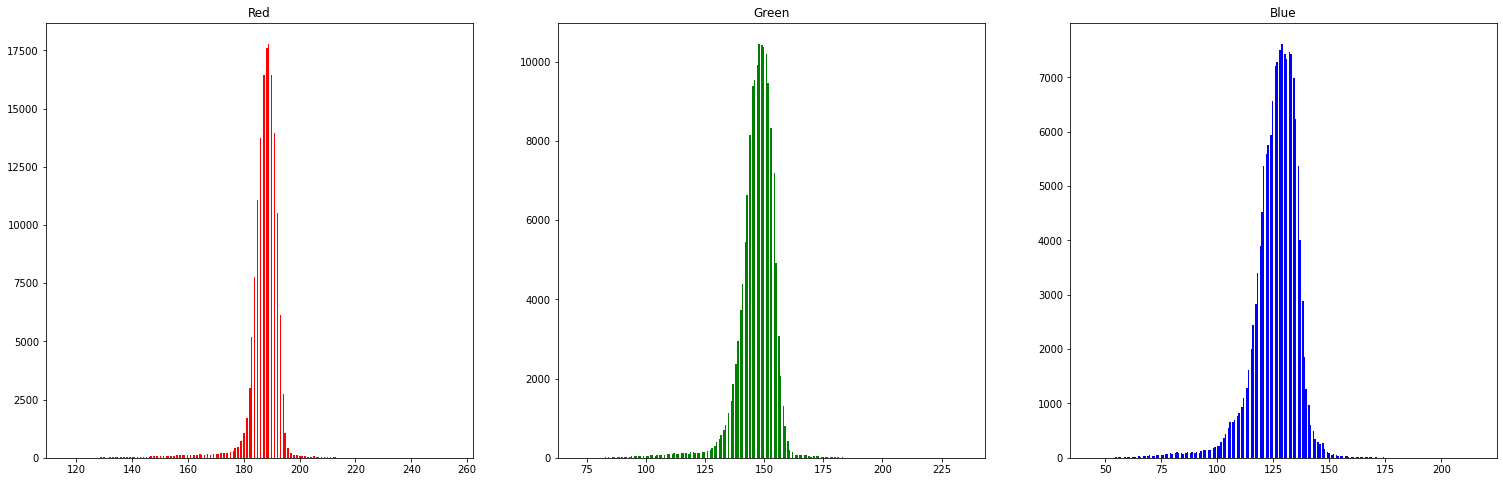

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(26,8))
ax[0].hist(cleanr,bins=255,color='red')
ax[0].set_title('Red')
ax[1].hist(cleang,bins=255,color='green')
ax[1].set_title("Green")
ax[2].hist(cleanb,bins=255,color='blue')
ax[2].set_title("Blue");

In [ ]:
#getting a symmetry value

def symcheck(outline):
    left={}
    right={}
    outlineset=set([x[0] for x in outline])#making a set with all column numbres in the outline
    rowset=set([x[1] for x in outline])#making a set with all row numbres in the outline
    mincol=min(outlineset)
    maxcol=max(outlineset)
    minrow=min(rowset)
    maxrow=max(rowset)
    middlerow=round((maxrow+minrow)/2)

    if (maxcol+mincol) % 2!=1:
        middlecol=int((maxcol+mincol)/2+0.5)
        for i in range(mincol,middlecol):
            left[i]=[]
        for i in range(middlecol+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol:
                left[i[0]].append(i[1])
            elif i[0]>middlecol:
                right[i[0]].append(i[1])
        even=False
    else:
        middlecol=[int((maxcol+mincol)/2),int((maxcol+mincol)/2+1)]
        for i in range(mincol,middlecol[0]):
            left[i]=[]
        for i in range(middlecol[1]+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol[0]:
                left[i[0]].append(i[1])
            elif i[0]>middlecol[1]:
                right[i[0]].append(i[1])
        even=True
    leftcounter=mincol
    rightcounter=maxcol
    leftdistance=0
    rightdistance=0
    for i in range(len(left)):
        for j in left[leftcounter]:
            curlist=right[rightcounter]
            distancelist=[abs(x-j) for x in curlist]
            closest=curlist[distancelist.index(min(distancelist))]
            if even==True:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol[0])**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol[1])**2)+(abs(closest-middlerow)**2))
            else:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol)**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol)**2)+(abs(closest-middlerow)**2))
        leftcounter+=1
        rightcounter-=1
    print('The vertical symmetry value for this shape is:', (math.log10(abs(rightdistance-leftdistance+1)))**2)
    return math.log10(abs(rightdistance-leftdistance+1))**2

In [ ]:
symcheck(outline) 

The vertical symmetry value for this shape is: 18.741915945275927


18.741915945275927

How this super awesome symmetry check works:

1) Split the outline of the shape in the middle assigning one or two middle columns depending on if the horizontal length is even or odd. Also assigns a middle row roughly.

2) Start with the leftmost column of pixels and get the distance to a fixed \[middlecol,middlerow] point, basically the centre, for each pixel in this column.

3) Sum all of these distances.

4) Then on the right side, it finds looks at which row the pixel in the left was in the related column, finds the nearest one here and calculates the distance to that same fixed point.

5) Then the result is given as $log10(abs(sumleft-sumright+1))^2$. This is done to get a human readable scale(we can change the scale cuz this is just a bit of an improvisation). 0 means the shape is symmetrical, higher values are less and less symmetrical

6) profit


# Task 0: Explore The Data

# Task 1: Implement Two Features

# Task 2: Predict The Diagnosis

# Task 3: Open Question

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c01f5965-259c-4c17-ae6d-879577586d70' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>